In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

<b> Select subsets for training, validation and testing </b>

In [9]:
all_subsets = list(range(0,10))
train_subsets = [3, 4, 5, 6, 7, 8] #[3]
val_subsets = [2, 9]
test_subsets = [0, 1]

<b> Dataset path and output paths </b>

In [10]:
data_path = '../dataset/'
annotations_path = '../dataset/CSVFILES/annotations.csv'
train_out_img_path = '../data/train/images/'
train_out_mask_path = '../data/train/masks/'
val_out_img_path = '../data/val/images/'
val_out_mask_path = '../data/val/masks/'
test_out_img_path = '../data/test/images/'
test_out_mask_path = '../data/test/masks/'

<b> Convert .mhd/.raw images to numpy arrays </b>

In [11]:
def get_subset_path(nr):
    return data_path + 'subset' + str(nr) + '/'

def get_file_path(id):
    global subset_mhd_files
    for file in subset_mhd_files:
        if id in file:
            return file

In [12]:
# Unkwnf
def make_mask(center,diam,z,width,height,spacing,origin):
    mask = np.zeros([height,width]) 
    
    v_center = (center-origin)/spacing
    v_diam = int((diam+5)/spacing[0])
    v_xmin = np.max([0,int(v_center[0]-v_diam)])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)])
    v_ymin = np.max([0,int(v_center[1]-v_diam)]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)
    
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [14]:
file_count = 0
for subset in train_subsets:
    
    # Get .mhd files
    cur_subset_path = get_subset_path(subset)
    subset_mhd_files = glob.glob(cur_subset_path + '*.mhd')
    
    # Read annotations.csv
    annot_df = pd.read_csv(annotations_path)
    # Add 'file' column & delete rows from other subsets
    annot_df['file'] = annot_df['seriesuid'].apply(get_file_path)
    annot_df = annot_df.dropna()
    
    # Desc str for tqdm
    progress_str = 'Analyzing set nr. ' + str(subset)
    for file in tqdm(subset_mhd_files, desc = progress_str):
        
        # Get nodules on this file
        nod_df = annot_df[annot_df['file'] == file]
        
        if len(nod_df) > 0:
            # If file has nodules (len > 0) proceed
            
            # TODO: now it takes only one nodule
            nod_x = nod_df['coordX'].values[0]
            nod_y = nod_df['coordY'].values[0]
            nod_z = nod_df['coordZ'].values[0]
            nod_mm = nod_df['diameter_mm'].values[0]
            
            # Read .mhd/.raw with SimpleITK
            itk_img = sitk.ReadImage(file)
            img_arr = sitk.GetArrayFromImage(itk_img) # Note! - arr from itk img is stored in (z, y, x) order !
            depth, height, width = img_arr.shape      # ------------------ "" -------------------
            
            # Get 1. nodule center 2. image origin 3. image spacing 4. nod center in voxel space
            nod_center = np.array([nod_x, nod_y, nod_z])
            img_origin = np.array(itk_img.GetOrigin())
            img_spacing = np.array(itk_img.GetSpacing())
            vox_center = np.rint((nod_center - img_origin) / img_spacing).astype(int)
            
            # Analyze 1mm before, 1mm of vox center, 1mm after
            for z in range(vox_center[2] - 1, vox_center[2] + 2):
                
                # Create mask
                mask = make_mask(nod_center, nod_mm, z * img_spacing[2] + img_origin[2],
                                 width, height, img_spacing, img_origin)
                
                # Take y between 100 and 400  and take x between 100 and 400
                img_slice = img_arr[z]
                img_middle = img_slice[100:400, 100:400]
                img_mean = np.mean(middle)
                img_max = np.max(img_slice)
                img_min = np.min(img_slice)
                
                img_slice[img_slice == max] = img_mean
                img_slice[img_slice == min] = img_mean
                
                # Save slices and masks
                np.save(train_out_img_path + 'image_' + str(file_count) + '.npy', img_slice)
                np.save(train_out_mask_path + 'mask_' + str(file_count) + '.npy', mask)
                
                file_count += 1

Analyzing set nr. 8: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s]


<b> Plot slice and mask </b>

In [25]:
ct_slice_1 = np.load(train_out_img_path + 'image_1.npy')
ct_slice_2 = np.load(train_out_img_path + 'image_10.npy')

mask_1 = np.load(train_out_mask_path + 'mask_1.npy')
mask_2 = np.load(train_out_mask_path + 'mask_10.npy')

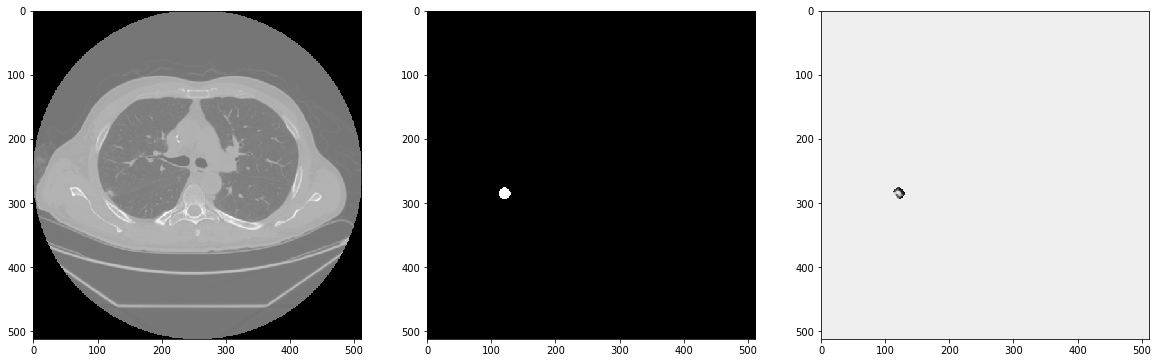

In [52]:
plt.figure(figsize = (20, 15))
plt.subplot(131)
plt.imshow(ct_slice_1, cmap = 'gray')
plt.subplot(132)
plt.imshow(mask_1, cmap = 'gray')
plt.subplot(133)
plt.imshow(ct_slice_1 * mask_1, cmap = 'gray')

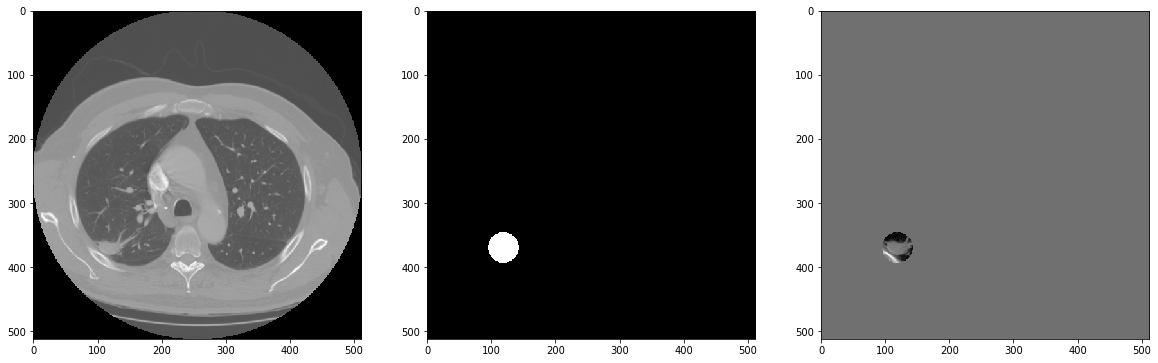

In [53]:
plt.figure(figsize = (20, 15))
plt.subplot(131)
plt.imshow(ct_slice_2, cmap = 'gray')
plt.subplot(132)
plt.imshow(mask_2, cmap = 'gray')
plt.subplot(133)
plt.imshow(ct_slice_2 * mask_2, cmap = 'gray')

----

In [56]:
pd.read_csv(annotations_path).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB
